### Import Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#CONSTS
READ_FOLDER_PATH = '../data/processed/'
WRITE_FOLDER_PATH = '../data/processed/'

data = pd.read_csv(READ_FOLDER_PATH+'aggregated_data.csv')

print(data.shape[0])
pd.set_option("display.max_colwidth", None) 

9074


### Initial RF Regression train and test
- The idea is that not all "1+ corners" cases are equal... e.g. a row where 4 corners occurred is not the same as a row where only 1 corner occurred. Thefore I am implementing the following strategy:

1) Train a Random Forest Regressor to predict the expected number of corners
2) Map the predictions to a Poisson distribution to estimate probabilities

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
#Func: Calculates prob of >= 1 more corner using Poisson:
def probability_at_least_one_corner(predicted_corners):
    return round(1-np.exp(-predicted_corners), 3) 

#Func: Convert probability to fair odds:
def implied_odds(predicted_corners):
    prob =probability_at_least_one_corner(predicted_corners)
    return round(1/prob, 3) if prob>0 else float('inf') 

# Feature columns to select
feature_columns = [
    # 'home_shots_pre80', 'away_shots_pre80', 'home_fouls_pre80', 'away_fouls_pre80',
    # 'home_corners_pre80', 'away_corners_pre80', 'home_yellow_cards_pre80', 'away_yellow_cards_pre80',
    # 'home_sending_off_pre80', 'away_sending_off_pre80', 
    'goal_diff_80',
    'home_corners_70_75', 'away_corners_70_75', 'home_shots_70_75', 'away_shots_70_75',
    'home_corners_75_80', 'away_corners_75_80', 'home_shots_75_80', 'away_shots_75_80',
    # 'home_fouls_70_75', 'away_fouls_70_75', 'home_fouls_70_75', 'away_fouls_70_75',
]

# Set target (i.e. num of corners post 80 minutes)
data['corner_diff'] = data['home_corner_diff'] + data['away_corner_diff']
target_column = "corner_diff"

X=data[feature_columns]
y=data[target_column]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42)
rf_regressor=RandomForestRegressor(n_estimators=500,max_depth=None,random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)
y_pred = np.round(y_pred, 3)

#Calc probabilities and implied odds for each prediction...
prob_at_least_1=[probability_at_least_one_corner(pred) for pred in y_pred]
implied_odds_list =[implied_odds(pred) for pred in y_pred]

#Create a df with features, actual corner difference, and predictions
pred_df =X_test.copy()
pred_df['corner_diff'] = y_test.values 
pred_df['y_pred'] = y_pred
pred_df['prob_at_least_1_corner'] =prob_at_least_1
pred_df['implied_odds'] = implied_odds_list

#Measures to eval model performnce:
mae= mean_absolute_error(y_test,y_pred)
mse =mean_squared_error(y_test, y_pred)
rmse= mse**0.5

print("\n### Model Performance ###")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared error (RMSE): {rmse:.4f}")

pred_df



### Model Performance ###
Mean Absolute Error (MAE): 1.0773
Mean squared Error (MSE): 1.8617
Root Mean Squared error (RMSE): 1.3644


,goal_diff_80,home_corners_70_75,away_corners_70_75,home_shots_70_75,away_shots_70_75,home_corners_75_80,away_corners_75_80,home_shots_75_80,away_shots_75_80,corner_diff,y_pred,prob_at_least_1_corner,implied_odds
447,0,0,0,2,0,0,0,0,2,0,1.115,0.672,1.488
5313,1,0,0,0,2,0,0,0,0,0,1.937,0.856,1.168
3412,3,1,0,0,0,0,0,1,0,4,2.317,0.901,1.110
4366,3,0,1,1,0,0,1,2,0,0,1.173,0.691,1.447
5284,1,0,1,0,0,0,0,0,0,0,1.731,0.823,1.215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0,1,0,3,0,1,0,2,0,1,1.792,0.833,1.200
4726,1,0,0,1,0,0,0,2,1,3,1.130,0.677,1.477
6664,1,0,0,0,0,0,0,0,1,1,1.583,0.795,1.258
4174,-1,0,0,0,0,0,0,0,1,0,1.340,0.738,1.355


### Plot Prediction Error
- y_pred - actual (corner_diff) for each prediction

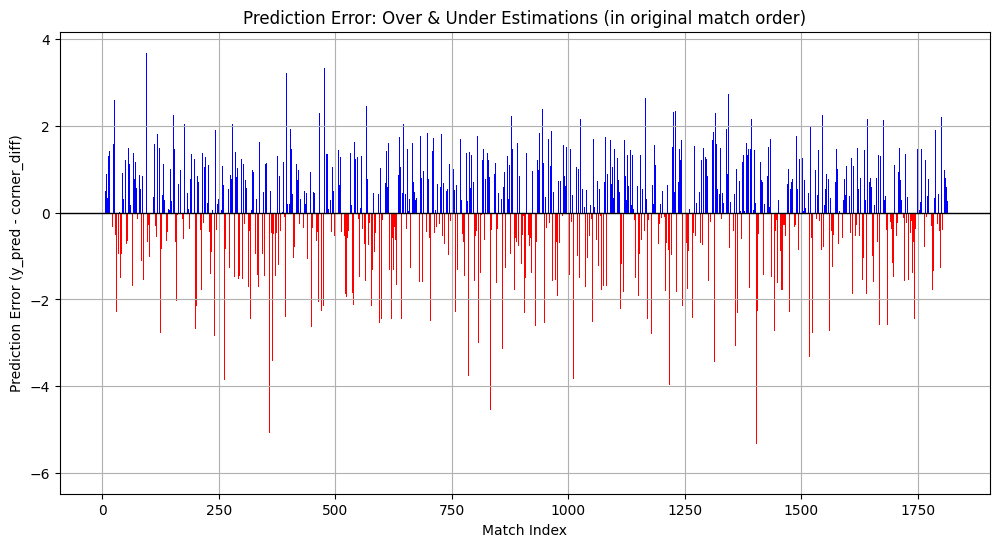

In [ ]:
#Compute prediction diff: y_pred - actual (corner_diff)
pred_df['prediction_error'] = pred_df['y_pred'] - pred_df['corner_diff']

#Plot chart in time order 
plt.figure(figsize=(12,6))
plt.bar(range(len(pred_df)),pred_df['prediction_error'], color=np.where(pred_df['prediction_error']>0, 'blue','red'))
plt.axhline(y=0, color='black', linewidth=1)  # Zero error reference line
plt.xlabel("Match Index")
plt.ylabel("Prediction Error (y_pred - corner_diff)")
plt.title("Prediction Error: Over & Under Estimations (in original match order)")
plt.grid(True)
plt.show() 

### Strategy 2: Split by pred >= 1
- Don't use Poisson this time, simply split if y_pred >= 1, and divide into our two classifications (1 and 0)


### Model Performance ###
True Positive Rate (TPR): 84.51%
Precision: 0.75
Recall: 0.85
Overall Accuracy:0.67

### Prediction on test set: ###
              precision    recall  f1-score   support

           0       0.23      0.14      0.17       446
           1       0.75      0.85      0.80      1369

    accuracy                           0.67      1815
   macro avg       0.49      0.49      0.48      1815
weighted avg       0.62      0.67      0.64      1815



<Figure size 500x500 with 0 Axes>

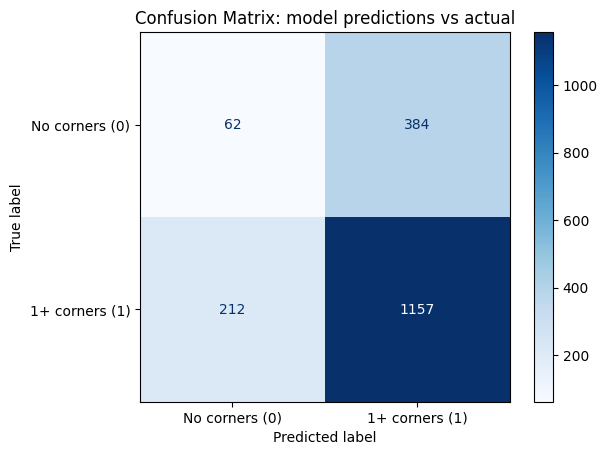

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
 
#Split into binary categories... 
pred_df['actual_bin'] = (pred_df['corner_diff'] >= 1).astype(int)  # 1 if 1+ corners, else 0
pred_df['predicted_bin'] = (pred_df['y_pred'] >= 1).astype(int)  # 1 if predicted 1+ corners, else 0

# Compute confusion matrix
cm = confusion_matrix(pred_df['actual_bin'], pred_df['predicted_bin'])

tn, fp, fn,tp = cm.ravel()  
accuracy = (tp+tn)/cm.sum()  
precision= tp/(tp+fp) if (tp +fp)>0 else 0
recall= tp/(tp+fn) if (tp+fn)>0 else 0
true_positive_rate=recall *100  

#Display results
print("\n### Model Performance ###")
print(f"True Positive Rate (TPR): {true_positive_rate:.2f}%")
print(f"Precision: {precision:.2f}") #KEY FACTOR FOR US
print(f"Recall: {recall:.2f}")
print(f"Overall Accuracy:{accuracy:.2f}") 
 
print("\n### Prediction on test set: ###")
print(classification_report(pred_df['actual_bin'], pred_df['predicted_bin']))

#Plot confusion matrix:
plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No corners (0)", "1+ corners (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: model predictions vs actual")
plt.grid(False)
plt.show() 


### Threshold Optimisation

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report
 
#initial threshold:
threshold = 1 
y_pred_bin = (pred_df['y_pred'] >= threshold).astype(int)
y_actual_bin=(pred_df['corner_diff']>=1).astype(int)
 
# Evaluate precision and recall
precision= precision_score(y_actual_bin, y_pred_bin) 
recall =recall_score(y_actual_bin, y_pred_bin)

print(f"\n### Model Evaluation at Threshold: {threshold} ###")
print(f"Precision: {precision:.4f}")  #higher precision = fewer false bets!
print(f"Recall: {recall:.4f}")  #lower recall = fewer bets placed
print("\n### Classification Report ###")
print(classification_report(y_actual_bin, y_pred_bin)) 
 
# --- Threshold Optimisation ---
thresholds = np.linspace(0.8, 2.0, 7)
results = [] 
 
for t in thresholds: 
    y_pred_t =(pred_df['y_pred'] >= t).astype(int)
    precision_t = precision_score(y_actual_bin,y_pred_t)
    recall_t =recall_score(y_actual_bin, y_pred_t)
    results.append((t,precision_t,recall_t))
  
print("\n### Precision-Recall Tradeoff at Different Thresholds ###")
print(f"{'Threshold':<12}{'Precision':<12}{'Recall':<12}")
print("-" * 36)
for t, p, r in results:
    print(f"{t:<12.2f}{p:<12.4f}{r:<12.4f}")
   
#Best threshold...
best_threshold =max(results,key=lambda x: x[1])
print("\n### Recommended Threshold for Maximum Precision ###")
print(f"Optimal Threshold: {best_threshold[0]:.2f}")
print(f"Expected Precision: {best_threshold[1]:.4f}")
print(f"Expected Recall: {best_threshold[2]:.4f}")



### Model Evaluation at Threshold: 1 ###
Precision: 0.7508
Recall: 0.8451

### Classification Report ###
              precision    recall  f1-score   support

           0       0.23      0.14      0.17       446
           1       0.75      0.85      0.80      1369

    accuracy                           0.67      1815
   macro avg       0.49      0.49      0.48      1815
weighted avg       0.62      0.67      0.64      1815


### Precision-Recall Tradeoff at Different Thresholds ###
Threshold   Precision   Recall      
------------------------------------
0.80        0.7529      0.9145      
1.00        0.7508      0.8451      
1.20        0.7599      0.7283      
1.40        0.7703      0.5829      
1.60        0.7783      0.3616      
1.80        0.7727      0.2235      
2.00        0.7802      0.1322      

### Recommended Threshold for Maximum Precision ###
Optimal Threshold: 2.00
Expected Precision: 0.7802
Expected Recall: 0.1322
